In [3]:
import os, math
from collections import defaultdict, namedtuple
import itertools
import sqlite3
import logging
import logging.handlers
import pickle
import datetime

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [4]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'sim'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [6]:
log = logging.getLogger('kmslog')
log.setLevel(logging.DEBUG)

if not log.hasHandlers():
    log.addHandler(logging.handlers.SysLogHandler(address = '/dev/log', facility=logging.handlers.SysLogHandler.LOG_LOCAL0))

config_var = 'SQLITE3_NORMAL_GRID_RADIAL_7_256'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

xp = cupy


In [7]:
hdc = Hdc(10_000, xp)

In [8]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 15 μs, sys: 3 μs, total: 18 μs
Wall time: 37.9 μs


((10000, 3), (2000, 3))


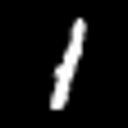
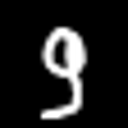
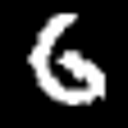
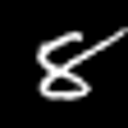
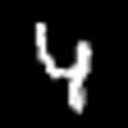
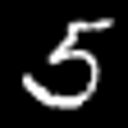
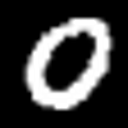
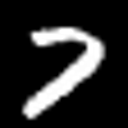
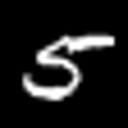
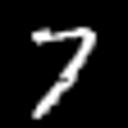
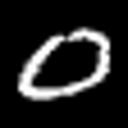
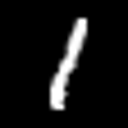
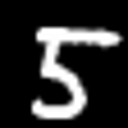
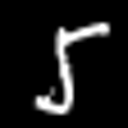
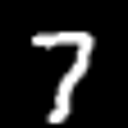
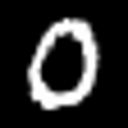

In [9]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [10]:
class Engram(object):
    def __init__(self):
        self.hdv_bundle_uncapped_ = None
        self.hdv_bundle = None
        self.image_value = None
        self.image_ids = set()
        self.is_sealed = False
        self.updates_counter = 0

    @property
    def hdv_bundle_uncapped(self):
        return self.hdv_bundle_uncapped_

    @hdv_bundle_uncapped.setter
    def hdv_bundle_uncapped(self, h):
        self.hdv_bundle_uncapped_ = h
        self.hdv_bundle = xp.sign(h)
        self.updates_counter += 1

class CorticalColumn(object):
    def __init__(self):
        # engram = collection of related HDV aka prototype or collective image
        self.engrams = {} # key - index in engram_norms, value - Engram instance
        self.engram_norms = HdvArray(hdc.N, xp) # hot part of computation - normalized versions of engrams for fast cos sim calculation
        self.images_seen = 0

In [11]:
COLUMNS = {}
# COLUMNS = {-1: CorticalColumn()}
# COLUMNS.update(map(lambda i: (i, CorticalColumn()), range(1)))
COLUMNS.update(map(lambda i: (i, CorticalColumn()), range(config.cortical_columns_count)))

In [16]:
%%time

train_runs = 50
attempts_to_get_no_mistakes = 10
count = min(1000, len(df_train_images))
consolidation_threshold = 1000

for _ in tqdm(range(train_runs), desc='Train run'):
    TRAIN_RUN_ID += 1
    train_step_image_ids_orig = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for column_id, column in tqdm(COLUMNS.items(), desc='Column', leave=False):
        train_step_image_ids = train_step_image_ids_orig.copy()
        
        for attempt_to_get_no_mistakes in tqdm(range(attempts_to_get_no_mistakes), leave=False, desc='Attempt'):
            # 1) EVOLVE MEMORIES
            for image_no, image_id in tqdm(enumerate(train_step_image_ids), leave=False, total=len(train_step_image_ids), desc='Image (train)'):
                # 1.1) MINE ENGRAMS
                log_prefix = f'[TRRID={TRAIN_RUN_ID},COL={column_id},IMGNO={image_no},IMGID={image_id}]'
                log.debug(f'{log_prefix} Engrams count={column.engram_norms.len}')
                column.images_seen += 1
                
                image_value = df_train_images.loc[image_id]['value']
                df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                                 params={'image_id': int(image_id), 'column_id': column_id}, con=train_db_con)
                assert len(df_image_encodings) > 0
                image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
                image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
                image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)
        
                cos_sim_matrix = column.engram_norms.array_active @ image_encoding_hdvs_norm.T
                cos_sim_matrix[cos_sim_matrix < Hdc.COS_SIM_THRESHOLD] = 0
                cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
                
                assert cos_sim_vector.shape == (column.engram_norms.array_active.shape[0],)
                engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
                match_found = False
                match_pos = False
                match_is_updated = False
        
                for pos, engram_id in enumerate(engram_ids_by_match_score):
                    cos_sim_value = cos_sim_vector[engram_id]
                    log.debug(f'{log_prefix} Checking engram #{engram_id}, pos={pos}, sim={cos_sim_value:.2f}')
        
                    if cos_sim_value <= 0:
                        break

                    engram = column.engrams[engram_id]
        
                    if engram.image_value != image_value:
                        log.debug(f'{log_prefix} Match WRONG, engram value={engram.image_value} vs {image_value}')
                    else:
                        log.debug(f'{log_prefix} Match CORRECT, sealed={engram.is_sealed}')
        
                        if not engram.is_sealed:
                            engram.image_ids.add(image_id)
                            image_encoding_hdv_bundle = hdc.bundle(image_encoding_hdvs)
                            
                            engram.hdv_bundle_uncapped = xp.sum(xp.vstack([engram.hdv_bundle_uncapped, image_encoding_hdv_bundle]), axis=0)
                            column.engram_norms.array[engram_id] = hdc.normalize(engram.hdv_bundle)
                            
                            if engram.updates_counter > 200:
                                log.debug(f'{log_prefix} engram #{engram_id} (upd. counter={engram.updates_counter}) is sealed')
                                engram.is_sealed = True

                            match_is_updated = True
        
                        match_found = True
                        match_pos = pos
                        break
        
                log.debug(f'{log_prefix} Match found={match_found}, pos={match_pos}, is updated={match_is_updated}')
        
                if (match_found and match_pos == 0) or (match_found and match_is_updated):
                    pass
                else:
                    # Deploy new engram
                    engram_id = column.engram_norms.lease()
                    
                    engram = Engram()
                    engram.hdv_bundle_uncapped = xp.sum(xp.vstack(image_encoding_hdvs), axis=0)
                    engram.image_ids.add(image_id)
                    engram.image_value = image_value
                    
                    column.engram_norms.array[engram_id] = hdc.normalize(engram.hdv_bundle)
                    column.engrams[engram_id] = engram
                    log.debug(f'{log_prefix} New engram {engram_id}')

                # 1.2) CONSOLIDATE ENGRAMS
                if image_no > 0 and image_no % consolidation_threshold == 0:
                    def dump_engram_lengths(when):
                        engram_lengths = list(map(lambda e: len(e.image_ids), column.engrams.values()))
                        engram_lengths = np.unique_counts(engram_lengths)
                        
                        for v, c in zip(reversed(engram_lengths.values), reversed(engram_lengths.counts)):
                            log.debug(f'{log_prefix}[CONSOLIDATION] {when:10} {v:5} {c:5}')
        
                    before_len = column.engram_norms.len()
                    assert before_len == len(column.engrams)
                    
                    log.debug(f'{log_prefix}[CONSOLIDATION] BEFORE engrams count = {before_len}')
                    dump_engram_lengths('BEFORE')
                    
                    engram_ids_to_release = []
                    
                    for engram_id, engram in column.engrams.items():
                        #l = 0.1
                        l = 1
                        exp_distro_level = l * np.exp(-l * len(engram.image_ids))
                        rand_level = RNG.random()
                        do_release = rand_level < exp_distro_level
                        
                        if do_release:
                            engram_ids_to_release.append(engram_id)
                            log.debug(f'{log_prefix}[CONSOLIDATION] Dropping engram #{engram_id}, len={len(engram.image_ids)}: {rand_level:.5f} < {exp_distro_level:.5f}')
                
                    for engram_id_to_release in engram_ids_to_release:
                        del column.engrams[engram_id_to_release]
                        column.engram_norms.release(engram_id_to_release)
                
                    after_len = column.engram_norms.len()
                    assert after_len == len(column.engrams)
                    
                    log.debug(f'{log_prefix}[CONSOLIDATION] AFTER engrams count = {after_len}')
                    dump_engram_lengths('AFTER')

            # 2) DETECT MISTAKES FOR CONSEQUENT FIX
            mistake_image_ids = []
            
            for image_no, image_id in tqdm(enumerate(train_step_image_ids), leave=False, total=len(train_step_image_ids), desc='Image (test)'):
                image_value = df_train_images.loc[image_id]['value']
                df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                                 params={'image_id': int(image_id), 'column_id': column_id}, con=train_db_con)
                assert len(df_image_encodings) > 0
                image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
                image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
                image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)
            
                cos_sim_matrix = column.engram_norms.array_active @ image_encoding_hdvs_norm.T
                cos_sim_matrix[cos_sim_matrix < Hdc.COS_SIM_THRESHOLD] = 0
                cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
                
                assert cos_sim_vector.shape == (column.engram_norms.array_active.shape[0],)
                engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
            
                if engram_ids_by_match_score.shape[0] > 0:
                    engram_id = engram_ids_by_match_score[0]
                    cos_sim_value = cos_sim_vector[engram_id]
            
                    if cos_sim_value > 0:
                        engram_image_value = column.engrams[engram_id].image_value
    
                        if engram_image_value != image_value:
                            mistake_image_ids.append(image_id)

            log.debug(f'[TRRID={TRAIN_RUN_ID}] Mistaken image ids = {len(mistake_image_ids)}')
            train_step_image_ids = mistake_image_ids

Train run:   0%|          | 0/50 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/62 [00:00<?, ?it/s]

Image (test):   0%|          | 0/62 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/136 [00:00<?, ?it/s]

Image (test):   0%|          | 0/136 [00:00<?, ?it/s]

Image (train):   0%|          | 0/122 [00:00<?, ?it/s]

Image (test):   0%|          | 0/122 [00:00<?, ?it/s]

Image (train):   0%|          | 0/102 [00:00<?, ?it/s]

Image (test):   0%|          | 0/102 [00:00<?, ?it/s]

Image (train):   0%|          | 0/89 [00:00<?, ?it/s]

Image (test):   0%|          | 0/89 [00:00<?, ?it/s]

Image (train):   0%|          | 0/82 [00:00<?, ?it/s]

Image (test):   0%|          | 0/82 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/71 [00:00<?, ?it/s]

Image (test):   0%|          | 0/71 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/139 [00:00<?, ?it/s]

Image (test):   0%|          | 0/139 [00:00<?, ?it/s]

Image (train):   0%|          | 0/120 [00:00<?, ?it/s]

Image (test):   0%|          | 0/120 [00:00<?, ?it/s]

Image (train):   0%|          | 0/103 [00:00<?, ?it/s]

Image (test):   0%|          | 0/103 [00:00<?, ?it/s]

Image (train):   0%|          | 0/92 [00:00<?, ?it/s]

Image (test):   0%|          | 0/92 [00:00<?, ?it/s]

Image (train):   0%|          | 0/81 [00:00<?, ?it/s]

Image (test):   0%|          | 0/81 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/67 [00:00<?, ?it/s]

Image (test):   0%|          | 0/67 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/125 [00:00<?, ?it/s]

Image (test):   0%|          | 0/125 [00:00<?, ?it/s]

Image (train):   0%|          | 0/108 [00:00<?, ?it/s]

Image (test):   0%|          | 0/108 [00:00<?, ?it/s]

Image (train):   0%|          | 0/94 [00:00<?, ?it/s]

Image (test):   0%|          | 0/94 [00:00<?, ?it/s]

Image (train):   0%|          | 0/80 [00:00<?, ?it/s]

Image (test):   0%|          | 0/80 [00:00<?, ?it/s]

Image (train):   0%|          | 0/65 [00:00<?, ?it/s]

Image (test):   0%|          | 0/65 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/128 [00:00<?, ?it/s]

Image (test):   0%|          | 0/128 [00:00<?, ?it/s]

Image (train):   0%|          | 0/103 [00:00<?, ?it/s]

Image (test):   0%|          | 0/103 [00:00<?, ?it/s]

Image (train):   0%|          | 0/90 [00:00<?, ?it/s]

Image (test):   0%|          | 0/90 [00:00<?, ?it/s]

Image (train):   0%|          | 0/74 [00:00<?, ?it/s]

Image (test):   0%|          | 0/74 [00:00<?, ?it/s]

Image (train):   0%|          | 0/61 [00:00<?, ?it/s]

Image (test):   0%|          | 0/61 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/117 [00:00<?, ?it/s]

Image (test):   0%|          | 0/117 [00:00<?, ?it/s]

Image (train):   0%|          | 0/97 [00:00<?, ?it/s]

Image (test):   0%|          | 0/97 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/97 [00:00<?, ?it/s]

Image (test):   0%|          | 0/97 [00:00<?, ?it/s]

Image (train):   0%|          | 0/88 [00:00<?, ?it/s]

Image (test):   0%|          | 0/88 [00:00<?, ?it/s]

Image (train):   0%|          | 0/81 [00:00<?, ?it/s]

Image (test):   0%|          | 0/81 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/148 [00:00<?, ?it/s]

Image (test):   0%|          | 0/148 [00:00<?, ?it/s]

Image (train):   0%|          | 0/126 [00:00<?, ?it/s]

Image (test):   0%|          | 0/126 [00:00<?, ?it/s]

Image (train):   0%|          | 0/117 [00:00<?, ?it/s]

Image (test):   0%|          | 0/117 [00:00<?, ?it/s]

Image (train):   0%|          | 0/101 [00:00<?, ?it/s]

Image (test):   0%|          | 0/101 [00:00<?, ?it/s]

Image (train):   0%|          | 0/97 [00:00<?, ?it/s]

Image (test):   0%|          | 0/97 [00:00<?, ?it/s]

Image (train):   0%|          | 0/85 [00:00<?, ?it/s]

Image (test):   0%|          | 0/85 [00:00<?, ?it/s]

Image (train):   0%|          | 0/77 [00:00<?, ?it/s]

Image (test):   0%|          | 0/77 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/62 [00:00<?, ?it/s]

Image (test):   0%|          | 0/62 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/118 [00:00<?, ?it/s]

Image (test):   0%|          | 0/118 [00:00<?, ?it/s]

Image (train):   0%|          | 0/101 [00:00<?, ?it/s]

Image (test):   0%|          | 0/101 [00:00<?, ?it/s]

Image (train):   0%|          | 0/91 [00:00<?, ?it/s]

Image (test):   0%|          | 0/91 [00:00<?, ?it/s]

Image (train):   0%|          | 0/79 [00:00<?, ?it/s]

Image (test):   0%|          | 0/79 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/134 [00:00<?, ?it/s]

Image (test):   0%|          | 0/134 [00:00<?, ?it/s]

Image (train):   0%|          | 0/117 [00:00<?, ?it/s]

Image (test):   0%|          | 0/117 [00:00<?, ?it/s]

Image (train):   0%|          | 0/103 [00:00<?, ?it/s]

Image (test):   0%|          | 0/103 [00:00<?, ?it/s]

Image (train):   0%|          | 0/92 [00:00<?, ?it/s]

Image (test):   0%|          | 0/92 [00:00<?, ?it/s]

Image (train):   0%|          | 0/85 [00:00<?, ?it/s]

Image (test):   0%|          | 0/85 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/66 [00:00<?, ?it/s]

Image (test):   0%|          | 0/66 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/121 [00:00<?, ?it/s]

Image (test):   0%|          | 0/121 [00:00<?, ?it/s]

Image (train):   0%|          | 0/103 [00:00<?, ?it/s]

Image (test):   0%|          | 0/103 [00:00<?, ?it/s]

Image (train):   0%|          | 0/90 [00:00<?, ?it/s]

Image (test):   0%|          | 0/90 [00:00<?, ?it/s]

Image (train):   0%|          | 0/79 [00:00<?, ?it/s]

Image (test):   0%|          | 0/79 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/111 [00:00<?, ?it/s]

Image (test):   0%|          | 0/111 [00:00<?, ?it/s]

Image (train):   0%|          | 0/92 [00:00<?, ?it/s]

Image (test):   0%|          | 0/92 [00:00<?, ?it/s]

Image (train):   0%|          | 0/83 [00:00<?, ?it/s]

Image (test):   0%|          | 0/83 [00:00<?, ?it/s]

Image (train):   0%|          | 0/75 [00:00<?, ?it/s]

Image (test):   0%|          | 0/75 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/105 [00:00<?, ?it/s]

Image (test):   0%|          | 0/105 [00:00<?, ?it/s]

Image (train):   0%|          | 0/88 [00:00<?, ?it/s]

Image (test):   0%|          | 0/88 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/61 [00:00<?, ?it/s]

Image (test):   0%|          | 0/61 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/158 [00:00<?, ?it/s]

Image (test):   0%|          | 0/158 [00:00<?, ?it/s]

Image (train):   0%|          | 0/124 [00:00<?, ?it/s]

Image (test):   0%|          | 0/124 [00:00<?, ?it/s]

Image (train):   0%|          | 0/111 [00:00<?, ?it/s]

Image (test):   0%|          | 0/111 [00:00<?, ?it/s]

Image (train):   0%|          | 0/102 [00:00<?, ?it/s]

Image (test):   0%|          | 0/102 [00:00<?, ?it/s]

Image (train):   0%|          | 0/88 [00:00<?, ?it/s]

Image (test):   0%|          | 0/88 [00:00<?, ?it/s]

Image (train):   0%|          | 0/74 [00:00<?, ?it/s]

Image (test):   0%|          | 0/74 [00:00<?, ?it/s]

Image (train):   0%|          | 0/66 [00:00<?, ?it/s]

Image (test):   0%|          | 0/66 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/136 [00:00<?, ?it/s]

Image (test):   0%|          | 0/136 [00:00<?, ?it/s]

Image (train):   0%|          | 0/114 [00:00<?, ?it/s]

Image (test):   0%|          | 0/114 [00:00<?, ?it/s]

Image (train):   0%|          | 0/99 [00:00<?, ?it/s]

Image (test):   0%|          | 0/99 [00:00<?, ?it/s]

Image (train):   0%|          | 0/86 [00:00<?, ?it/s]

Image (test):   0%|          | 0/86 [00:00<?, ?it/s]

Image (train):   0%|          | 0/74 [00:00<?, ?it/s]

Image (test):   0%|          | 0/74 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/133 [00:00<?, ?it/s]

Image (test):   0%|          | 0/133 [00:00<?, ?it/s]

Image (train):   0%|          | 0/97 [00:00<?, ?it/s]

Image (test):   0%|          | 0/97 [00:00<?, ?it/s]

Image (train):   0%|          | 0/88 [00:00<?, ?it/s]

Image (test):   0%|          | 0/88 [00:00<?, ?it/s]

Image (train):   0%|          | 0/78 [00:00<?, ?it/s]

Image (test):   0%|          | 0/78 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/109 [00:00<?, ?it/s]

Image (test):   0%|          | 0/109 [00:00<?, ?it/s]

Image (train):   0%|          | 0/88 [00:00<?, ?it/s]

Image (test):   0%|          | 0/88 [00:00<?, ?it/s]

Image (train):   0%|          | 0/74 [00:00<?, ?it/s]

Image (test):   0%|          | 0/74 [00:00<?, ?it/s]

Image (train):   0%|          | 0/69 [00:00<?, ?it/s]

Image (test):   0%|          | 0/69 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/124 [00:00<?, ?it/s]

Image (test):   0%|          | 0/124 [00:00<?, ?it/s]

Image (train):   0%|          | 0/102 [00:00<?, ?it/s]

Image (test):   0%|          | 0/102 [00:00<?, ?it/s]

Image (train):   0%|          | 0/81 [00:00<?, ?it/s]

Image (test):   0%|          | 0/81 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/93 [00:00<?, ?it/s]

Image (test):   0%|          | 0/93 [00:00<?, ?it/s]

Image (train):   0%|          | 0/81 [00:00<?, ?it/s]

Image (test):   0%|          | 0/81 [00:00<?, ?it/s]

Image (train):   0%|          | 0/71 [00:00<?, ?it/s]

Image (test):   0%|          | 0/71 [00:00<?, ?it/s]

Image (train):   0%|          | 0/62 [00:00<?, ?it/s]

Image (test):   0%|          | 0/62 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/116 [00:00<?, ?it/s]

Image (test):   0%|          | 0/116 [00:00<?, ?it/s]

Image (train):   0%|          | 0/102 [00:00<?, ?it/s]

Image (test):   0%|          | 0/102 [00:00<?, ?it/s]

Image (train):   0%|          | 0/93 [00:00<?, ?it/s]

Image (test):   0%|          | 0/93 [00:00<?, ?it/s]

Image (train):   0%|          | 0/74 [00:00<?, ?it/s]

Image (test):   0%|          | 0/74 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/120 [00:00<?, ?it/s]

Image (test):   0%|          | 0/120 [00:00<?, ?it/s]

Image (train):   0%|          | 0/102 [00:00<?, ?it/s]

Image (test):   0%|          | 0/102 [00:00<?, ?it/s]

Image (train):   0%|          | 0/81 [00:00<?, ?it/s]

Image (test):   0%|          | 0/81 [00:00<?, ?it/s]

Image (train):   0%|          | 0/69 [00:00<?, ?it/s]

Image (test):   0%|          | 0/69 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/118 [00:00<?, ?it/s]

Image (test):   0%|          | 0/118 [00:00<?, ?it/s]

Image (train):   0%|          | 0/101 [00:00<?, ?it/s]

Image (test):   0%|          | 0/101 [00:00<?, ?it/s]

Image (train):   0%|          | 0/88 [00:00<?, ?it/s]

Image (test):   0%|          | 0/88 [00:00<?, ?it/s]

Image (train):   0%|          | 0/75 [00:00<?, ?it/s]

Image (test):   0%|          | 0/75 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/105 [00:00<?, ?it/s]

Image (test):   0%|          | 0/105 [00:00<?, ?it/s]

Image (train):   0%|          | 0/78 [00:00<?, ?it/s]

Image (test):   0%|          | 0/78 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/126 [00:00<?, ?it/s]

Image (test):   0%|          | 0/126 [00:00<?, ?it/s]

Image (train):   0%|          | 0/96 [00:00<?, ?it/s]

Image (test):   0%|          | 0/96 [00:00<?, ?it/s]

Image (train):   0%|          | 0/77 [00:00<?, ?it/s]

Image (test):   0%|          | 0/77 [00:00<?, ?it/s]

Image (train):   0%|          | 0/62 [00:00<?, ?it/s]

Image (test):   0%|          | 0/62 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/88 [00:00<?, ?it/s]

Image (test):   0%|          | 0/88 [00:00<?, ?it/s]

Image (train):   0%|          | 0/69 [00:00<?, ?it/s]

Image (test):   0%|          | 0/69 [00:00<?, ?it/s]

Image (train):   0%|          | 0/62 [00:00<?, ?it/s]

Image (test):   0%|          | 0/62 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/109 [00:00<?, ?it/s]

Image (test):   0%|          | 0/109 [00:00<?, ?it/s]

Image (train):   0%|          | 0/98 [00:00<?, ?it/s]

Image (test):   0%|          | 0/98 [00:00<?, ?it/s]

Image (train):   0%|          | 0/94 [00:00<?, ?it/s]

Image (test):   0%|          | 0/94 [00:00<?, ?it/s]

Image (train):   0%|          | 0/82 [00:00<?, ?it/s]

Image (test):   0%|          | 0/82 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/128 [00:00<?, ?it/s]

Image (test):   0%|          | 0/128 [00:00<?, ?it/s]

Image (train):   0%|          | 0/112 [00:00<?, ?it/s]

Image (test):   0%|          | 0/112 [00:00<?, ?it/s]

Image (train):   0%|          | 0/91 [00:00<?, ?it/s]

Image (test):   0%|          | 0/91 [00:00<?, ?it/s]

Image (train):   0%|          | 0/80 [00:00<?, ?it/s]

Image (test):   0%|          | 0/80 [00:00<?, ?it/s]

Image (train):   0%|          | 0/65 [00:00<?, ?it/s]

Image (test):   0%|          | 0/65 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/98 [00:00<?, ?it/s]

Image (test):   0%|          | 0/98 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/89 [00:00<?, ?it/s]

Image (test):   0%|          | 0/89 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/95 [00:00<?, ?it/s]

Image (test):   0%|          | 0/95 [00:00<?, ?it/s]

Image (train):   0%|          | 0/77 [00:00<?, ?it/s]

Image (test):   0%|          | 0/77 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/87 [00:00<?, ?it/s]

Image (test):   0%|          | 0/87 [00:00<?, ?it/s]

Image (train):   0%|          | 0/71 [00:00<?, ?it/s]

Image (test):   0%|          | 0/71 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/131 [00:00<?, ?it/s]

Image (test):   0%|          | 0/131 [00:00<?, ?it/s]

Image (train):   0%|          | 0/112 [00:00<?, ?it/s]

Image (test):   0%|          | 0/112 [00:00<?, ?it/s]

Image (train):   0%|          | 0/99 [00:00<?, ?it/s]

Image (test):   0%|          | 0/99 [00:00<?, ?it/s]

Image (train):   0%|          | 0/84 [00:00<?, ?it/s]

Image (test):   0%|          | 0/84 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/66 [00:00<?, ?it/s]

Image (test):   0%|          | 0/66 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/97 [00:00<?, ?it/s]

Image (test):   0%|          | 0/97 [00:00<?, ?it/s]

Image (train):   0%|          | 0/75 [00:00<?, ?it/s]

Image (test):   0%|          | 0/75 [00:00<?, ?it/s]

Image (train):   0%|          | 0/61 [00:00<?, ?it/s]

Image (test):   0%|          | 0/61 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/104 [00:00<?, ?it/s]

Image (test):   0%|          | 0/104 [00:00<?, ?it/s]

Image (train):   0%|          | 0/82 [00:00<?, ?it/s]

Image (test):   0%|          | 0/82 [00:00<?, ?it/s]

Image (train):   0%|          | 0/65 [00:00<?, ?it/s]

Image (test):   0%|          | 0/65 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/99 [00:00<?, ?it/s]

Image (test):   0%|          | 0/99 [00:00<?, ?it/s]

Image (train):   0%|          | 0/80 [00:00<?, ?it/s]

Image (test):   0%|          | 0/80 [00:00<?, ?it/s]

Image (train):   0%|          | 0/71 [00:00<?, ?it/s]

Image (test):   0%|          | 0/71 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/103 [00:00<?, ?it/s]

Image (test):   0%|          | 0/103 [00:00<?, ?it/s]

Image (train):   0%|          | 0/84 [00:00<?, ?it/s]

Image (test):   0%|          | 0/84 [00:00<?, ?it/s]

Image (train):   0%|          | 0/65 [00:00<?, ?it/s]

Image (test):   0%|          | 0/65 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/73 [00:00<?, ?it/s]

Image (test):   0%|          | 0/73 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/119 [00:00<?, ?it/s]

Image (test):   0%|          | 0/119 [00:00<?, ?it/s]

Image (train):   0%|          | 0/100 [00:00<?, ?it/s]

Image (test):   0%|          | 0/100 [00:00<?, ?it/s]

Image (train):   0%|          | 0/87 [00:00<?, ?it/s]

Image (test):   0%|          | 0/87 [00:00<?, ?it/s]

Image (train):   0%|          | 0/78 [00:00<?, ?it/s]

Image (test):   0%|          | 0/78 [00:00<?, ?it/s]

Image (train):   0%|          | 0/71 [00:00<?, ?it/s]

Image (test):   0%|          | 0/71 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/87 [00:00<?, ?it/s]

Image (test):   0%|          | 0/87 [00:00<?, ?it/s]

Image (train):   0%|          | 0/69 [00:00<?, ?it/s]

Image (test):   0%|          | 0/69 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/94 [00:00<?, ?it/s]

Image (test):   0%|          | 0/94 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/74 [00:00<?, ?it/s]

Image (test):   0%|          | 0/74 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/103 [00:00<?, ?it/s]

Image (test):   0%|          | 0/103 [00:00<?, ?it/s]

Image (train):   0%|          | 0/83 [00:00<?, ?it/s]

Image (test):   0%|          | 0/83 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/92 [00:00<?, ?it/s]

Image (test):   0%|          | 0/92 [00:00<?, ?it/s]

Image (train):   0%|          | 0/73 [00:00<?, ?it/s]

Image (test):   0%|          | 0/73 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/93 [00:00<?, ?it/s]

Image (test):   0%|          | 0/93 [00:00<?, ?it/s]

Image (train):   0%|          | 0/80 [00:00<?, ?it/s]

Image (test):   0%|          | 0/80 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/71 [00:00<?, ?it/s]

Image (test):   0%|          | 0/71 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/69 [00:00<?, ?it/s]

Image (test):   0%|          | 0/69 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/100 [00:00<?, ?it/s]

Image (test):   0%|          | 0/100 [00:00<?, ?it/s]

Image (train):   0%|          | 0/80 [00:00<?, ?it/s]

Image (test):   0%|          | 0/80 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/74 [00:00<?, ?it/s]

Image (test):   0%|          | 0/74 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/89 [00:00<?, ?it/s]

Image (test):   0%|          | 0/89 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/86 [00:00<?, ?it/s]

Image (test):   0%|          | 0/86 [00:00<?, ?it/s]

Image (train):   0%|          | 0/65 [00:00<?, ?it/s]

Image (test):   0%|          | 0/65 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/91 [00:00<?, ?it/s]

Image (test):   0%|          | 0/91 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/94 [00:00<?, ?it/s]

Image (test):   0%|          | 0/94 [00:00<?, ?it/s]

Image (train):   0%|          | 0/80 [00:00<?, ?it/s]

Image (test):   0%|          | 0/80 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/73 [00:00<?, ?it/s]

Image (test):   0%|          | 0/73 [00:00<?, ?it/s]

Image (train):   0%|          | 0/62 [00:00<?, ?it/s]

Image (test):   0%|          | 0/62 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/104 [00:00<?, ?it/s]

Image (test):   0%|          | 0/104 [00:00<?, ?it/s]

Image (train):   0%|          | 0/87 [00:00<?, ?it/s]

Image (test):   0%|          | 0/87 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/84 [00:00<?, ?it/s]

Image (test):   0%|          | 0/84 [00:00<?, ?it/s]

Image (train):   0%|          | 0/67 [00:00<?, ?it/s]

Image (test):   0%|          | 0/67 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/105 [00:00<?, ?it/s]

Image (test):   0%|          | 0/105 [00:00<?, ?it/s]

Image (train):   0%|          | 0/91 [00:00<?, ?it/s]

Image (test):   0%|          | 0/91 [00:00<?, ?it/s]

Image (train):   0%|          | 0/77 [00:00<?, ?it/s]

Image (test):   0%|          | 0/77 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/79 [00:00<?, ?it/s]

Image (test):   0%|          | 0/79 [00:00<?, ?it/s]

Image (train):   0%|          | 0/62 [00:00<?, ?it/s]

Image (test):   0%|          | 0/62 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/94 [00:00<?, ?it/s]

Image (test):   0%|          | 0/94 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/75 [00:00<?, ?it/s]

Image (test):   0%|          | 0/75 [00:00<?, ?it/s]

Image (train):   0%|          | 0/61 [00:00<?, ?it/s]

Image (test):   0%|          | 0/61 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/82 [00:00<?, ?it/s]

Image (test):   0%|          | 0/82 [00:00<?, ?it/s]

Image (train):   0%|          | 0/66 [00:00<?, ?it/s]

Image (test):   0%|          | 0/66 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/87 [00:00<?, ?it/s]

Image (test):   0%|          | 0/87 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/69 [00:00<?, ?it/s]

Image (test):   0%|          | 0/69 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/88 [00:00<?, ?it/s]

Image (test):   0%|          | 0/88 [00:00<?, ?it/s]

Image (train):   0%|          | 0/66 [00:00<?, ?it/s]

Image (test):   0%|          | 0/66 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/67 [00:00<?, ?it/s]

Image (test):   0%|          | 0/67 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/94 [00:00<?, ?it/s]

Image (test):   0%|          | 0/94 [00:00<?, ?it/s]

Image (train):   0%|          | 0/81 [00:00<?, ?it/s]

Image (test):   0%|          | 0/81 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/73 [00:00<?, ?it/s]

Image (test):   0%|          | 0/73 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/67 [00:00<?, ?it/s]

Image (test):   0%|          | 0/67 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/85 [00:00<?, ?it/s]

Image (test):   0%|          | 0/85 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/85 [00:00<?, ?it/s]

Image (test):   0%|          | 0/85 [00:00<?, ?it/s]

Image (train):   0%|          | 0/69 [00:00<?, ?it/s]

Image (test):   0%|          | 0/69 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/83 [00:00<?, ?it/s]

Image (test):   0%|          | 0/83 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/70 [00:00<?, ?it/s]

Image (test):   0%|          | 0/70 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/61 [00:00<?, ?it/s]

Image (test):   0%|          | 0/61 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/61 [00:00<?, ?it/s]

Image (test):   0%|          | 0/61 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/57 [00:00<?, ?it/s]

Image (test):   0%|          | 0/57 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/76 [00:00<?, ?it/s]

Image (test):   0%|          | 0/76 [00:00<?, ?it/s]

Image (train):   0%|          | 0/62 [00:00<?, ?it/s]

Image (test):   0%|          | 0/62 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/72 [00:00<?, ?it/s]

Image (test):   0%|          | 0/72 [00:00<?, ?it/s]

Image (train):   0%|          | 0/65 [00:00<?, ?it/s]

Image (test):   0%|          | 0/65 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/64 [00:00<?, ?it/s]

Image (test):   0%|          | 0/64 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/66 [00:00<?, ?it/s]

Image (test):   0%|          | 0/66 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/56 [00:00<?, ?it/s]

Image (test):   0%|          | 0/56 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/60 [00:00<?, ?it/s]

Image (test):   0%|          | 0/60 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/68 [00:00<?, ?it/s]

Image (test):   0%|          | 0/68 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/61 [00:00<?, ?it/s]

Image (test):   0%|          | 0/61 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/65 [00:00<?, ?it/s]

Image (test):   0%|          | 0/65 [00:00<?, ?it/s]

Image (train):   0%|          | 0/46 [00:00<?, ?it/s]

Image (test):   0%|          | 0/46 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/59 [00:00<?, ?it/s]

Image (test):   0%|          | 0/59 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/63 [00:00<?, ?it/s]

Image (test):   0%|          | 0/63 [00:00<?, ?it/s]

Image (train):   0%|          | 0/52 [00:00<?, ?it/s]

Image (test):   0%|          | 0/52 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/51 [00:00<?, ?it/s]

Image (test):   0%|          | 0/51 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/45 [00:00<?, ?it/s]

Image (test):   0%|          | 0/45 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/58 [00:00<?, ?it/s]

Image (test):   0%|          | 0/58 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/53 [00:00<?, ?it/s]

Image (test):   0%|          | 0/53 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/54 [00:00<?, ?it/s]

Image (test):   0%|          | 0/54 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/49 [00:00<?, ?it/s]

Image (test):   0%|          | 0/49 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/38 [00:00<?, ?it/s]

Image (test):   0%|          | 0/38 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/41 [00:00<?, ?it/s]

Image (test):   0%|          | 0/41 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/44 [00:00<?, ?it/s]

Image (test):   0%|          | 0/44 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/55 [00:00<?, ?it/s]

Image (test):   0%|          | 0/55 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/39 [00:00<?, ?it/s]

Image (test):   0%|          | 0/39 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/48 [00:00<?, ?it/s]

Image (test):   0%|          | 0/48 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/50 [00:00<?, ?it/s]

Image (test):   0%|          | 0/50 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/43 [00:00<?, ?it/s]

Image (test):   0%|          | 0/43 [00:00<?, ?it/s]

Image (train):   0%|          | 0/37 [00:00<?, ?it/s]

Image (test):   0%|          | 0/37 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/47 [00:00<?, ?it/s]

Image (test):   0%|          | 0/47 [00:00<?, ?it/s]

Image (train):   0%|          | 0/36 [00:00<?, ?it/s]

Image (test):   0%|          | 0/36 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/40 [00:00<?, ?it/s]

Image (test):   0%|          | 0/40 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/35 [00:00<?, ?it/s]

Image (test):   0%|          | 0/35 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/32 [00:00<?, ?it/s]

Image (test):   0%|          | 0/32 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/42 [00:00<?, ?it/s]

Image (test):   0%|          | 0/42 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/29 [00:00<?, ?it/s]

Image (test):   0%|          | 0/29 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/33 [00:00<?, ?it/s]

Image (test):   0%|          | 0/33 [00:00<?, ?it/s]

Image (train):   0%|          | 0/31 [00:00<?, ?it/s]

Image (test):   0%|          | 0/31 [00:00<?, ?it/s]

Image (train):   0%|          | 0/28 [00:00<?, ?it/s]

Image (test):   0%|          | 0/28 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/34 [00:00<?, ?it/s]

Image (test):   0%|          | 0/34 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/26 [00:00<?, ?it/s]

Image (test):   0%|          | 0/26 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/30 [00:00<?, ?it/s]

Image (test):   0%|          | 0/30 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/24 [00:00<?, ?it/s]

Image (test):   0%|          | 0/24 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/23 [00:00<?, ?it/s]

Image (test):   0%|          | 0/23 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/27 [00:00<?, ?it/s]

Image (test):   0%|          | 0/27 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/25 [00:00<?, ?it/s]

Image (test):   0%|          | 0/25 [00:00<?, ?it/s]

Image (train):   0%|          | 0/19 [00:00<?, ?it/s]

Image (test):   0%|          | 0/19 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Column:   0%|          | 0/7 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/22 [00:00<?, ?it/s]

Image (test):   0%|          | 0/22 [00:00<?, ?it/s]

Image (train):   0%|          | 0/13 [00:00<?, ?it/s]

Image (test):   0%|          | 0/13 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/21 [00:00<?, ?it/s]

Image (test):   0%|          | 0/21 [00:00<?, ?it/s]

Image (train):   0%|          | 0/17 [00:00<?, ?it/s]

Image (test):   0%|          | 0/17 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/10 [00:00<?, ?it/s]

Image (test):   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/9 [00:00<?, ?it/s]

Image (test):   0%|          | 0/9 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/20 [00:00<?, ?it/s]

Image (test):   0%|          | 0/20 [00:00<?, ?it/s]

Image (train):   0%|          | 0/16 [00:00<?, ?it/s]

Image (test):   0%|          | 0/16 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/18 [00:00<?, ?it/s]

Image (test):   0%|          | 0/18 [00:00<?, ?it/s]

Image (train):   0%|          | 0/14 [00:00<?, ?it/s]

Image (test):   0%|          | 0/14 [00:00<?, ?it/s]

Image (train):   0%|          | 0/12 [00:00<?, ?it/s]

Image (test):   0%|          | 0/12 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/8 [00:00<?, ?it/s]

Image (test):   0%|          | 0/8 [00:00<?, ?it/s]

Image (train):   0%|          | 0/6 [00:00<?, ?it/s]

Image (test):   0%|          | 0/6 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1 [00:00<?, ?it/s]

Attempt:   0%|          | 0/10 [00:00<?, ?it/s]

Image (train):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (test):   0%|          | 0/1000 [00:00<?, ?it/s]

Image (train):   0%|          | 0/15 [00:00<?, ?it/s]

Image (test):   0%|          | 0/15 [00:00<?, ?it/s]

Image (train):   0%|          | 0/11 [00:00<?, ?it/s]

Image (test):   0%|          | 0/11 [00:00<?, ?it/s]

Image (train):   0%|          | 0/7 [00:00<?, ?it/s]

Image (test):   0%|          | 0/7 [00:00<?, ?it/s]

Image (train):   0%|          | 0/5 [00:00<?, ?it/s]

Image (test):   0%|          | 0/5 [00:00<?, ?it/s]

Image (train):   0%|          | 0/4 [00:00<?, ?it/s]

Image (test):   0%|          | 0/4 [00:00<?, ?it/s]

Image (train):   0%|          | 0/3 [00:00<?, ?it/s]

Image (test):   0%|          | 0/3 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train):   0%|          | 0/2 [00:00<?, ?it/s]

Image (test):   0%|          | 0/2 [00:00<?, ?it/s]

Image (train): 0it [00:00, ?it/s]

Image (test): 0it [00:00, ?it/s]

CPU times: user 58min 29s, sys: 3min 4s, total: 1h 1min 34s
Wall time: 1h 1min 8s


In [18]:
def softmax(x):
    max_x = np.max(x)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x)
    return exp_x / sum_exp_x

def conflate(pdfs):    
    n = np.prod(pdfs, axis=0)
    d = n.sum()

    if np.isclose(d, 0):
        return np.zeros(len(pdfs))
        
    return n / d

In [19]:
# TEST RUN
TEST_RUN_ID += 1
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
count = min(2000, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
test_result_rows = defaultdict(list)
column_id_whitelist = COLUMNS.keys()
# column_id_whitelist = [3]
assert np.all(np.array(list(map(lambda i: i in COLUMNS, column_id_whitelist))) == 1)

for image_id in tqdm(test_image_ids):
    column_votes_vector = np.zeros(10)
    
    for column_id, column in COLUMNS.items():
        if not column_id in column_id_whitelist:
            continue
            
        max_cos_sim_index = -1 # aka engram id
        max_similar_engram_image_value = ''
        max_cos_sim = 0
    
        image_value = test_run_source[0].loc[image_id]['value']
        df_image_encodings = pd.read_sql('SELECT hdv FROM image_encodings WHERE image_id=:image_id AND column_id=:column_id', 
                                         params={'image_id': int(image_id), 'column_id': column_id}, con=test_run_source[1])
        assert len(df_image_encodings) > 0
        image_encoding_hdvs = list(map(lambda h: np.frombuffer(h, dtype='b'), df_image_encodings['hdv']))
        image_encoding_hdvs_norm = hdc.normalize(image_encoding_hdvs)
        image_encoding_hdvs_norm = xp_array_to_gpu(image_encoding_hdvs_norm)
    
        cos_sim_matrix = column.engram_norms.array_active @ image_encoding_hdvs_norm.T
        cos_sim_matrix[cos_sim_matrix < Hdc.COS_SIM_THRESHOLD] = 0
        cos_sim_vector = xp_array_from_gpu(xp.sum(cos_sim_matrix, axis=1)) # how each mem recall (sum cos sim) is close to current image
        
        assert cos_sim_vector.shape == (column.engram_norms.array_active.shape[0],)
        engram_ids_by_match_score = np.argsort(-cos_sim_vector) # sorted desc
    
        if engram_ids_by_match_score.shape[0] > 0:
            engram_id = engram_ids_by_match_score[0]
            cos_sim_value = cos_sim_vector[engram_id]
    
            if cos_sim_value > 0:
                max_cos_sim_index = engram_id
                max_similar_engram_image_value = column.engrams[engram_id].image_value
                max_cos_sim = cos_sim_value
                column_votes_vector[int(max_similar_engram_image_value)] += max_cos_sim

    infer_value = ''
    
    if np.any(column_votes_vector) > 0:
        digit_probabilities = softmax(column_votes_vector)
        infer_value = str(RNG.choice(10, p=digit_probabilities))
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append(sorted(column_id_whitelist))
    test_result_rows['train_images_count'].append(column.images_seen)
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value) 
    test_result_rows['sim'].append(column_votes_vector)
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

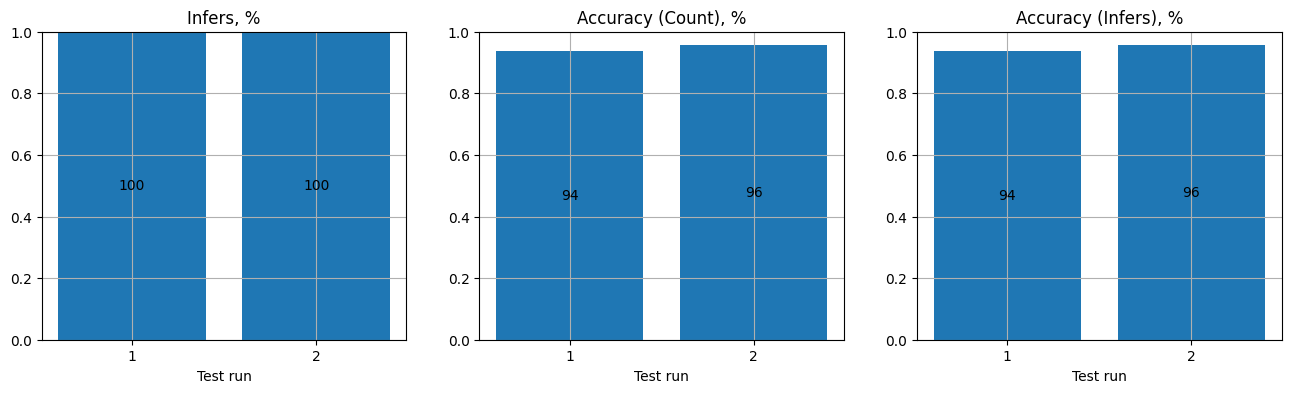

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
1,SQLITE3_NORMAL_GRID_RADIAL_7_256,test,"[0, 1, 2, 3, 4, 5, 6]",16666,10,2000,2000,1878,1.0,0.939,0.939
2,SQLITE3_NORMAL_GRID_RADIAL_7_256,test,"[0, 1, 2, 3, 4, 5, 6]",75759,60,2000,2000,1912,1.0,0.956,0.956


In [20]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2